# Analyzing Spotter data with CloudDrift

See [Spotter Technical Manual](https://content.sofarocean.com/hubfs/Spotter%20product%20documentation%20page/Sofar%20-%20Technical_Reference_Manual.pdf) for details on bulk wave parameters from directional wave buoys like Spotter.

This notebook demontrates using [CloudDrift](https://github.com/cloud-drift/clouddrift), a Python library for Lagrangian data analysis, to work with contiguous ragged arrays, such as the Spotter data archive.
We will load the data, subset it for a period of interest, and do some light kinematics analysis to demonstrate how CloudDrift can be used to process ragged arrays.

In [1]:
import cartopy.crs as ccrs
import clouddrift as cd
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## Load Spotter data

We remotely access Zarr files stored on S3. All data access methods remain the same if using the netCDF file downloaded locally, e.g., `ds = xr.load_dataset(local_filename)`. The xarray + zarr allows for efficient remote access of the data without full download, but requires an internet connection.

In [2]:
s3_uri = "https://sofar-spotter-archive.s3.amazonaws.com/spotter_data_bulk_zarr"
ds = xr.open_dataset(s3_uri, engine="zarr")
ds

<xarray.Dataset>
Dimensions:                (index: 6390651, trajectory: 871)
Coordinates:
    time                   (index) datetime64[ns] ...
  * trajectory             (trajectory) object 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    latitude               (index) float64 ...
    longitude              (index) float64 ...
    meanDirection          (index) float64 ...
    meanDirectionalSpread  (index) float64 ...
    meanPeriod             (index) float64 ...
    peakDirection          (index) float64 ...
    peakDirectionalSpread  (index) float64 ...
    peakPeriod             (index) float64 ...
    rowsize                (trajectory) int64 ...
    significantWaveHeight  (index) float64 ...
Attributes:
    author:         Isabel A. Houghton
    creation_date:  2023-10-18 00:43:55.333537
    email:          isabel.houghton@sofarocean.com
    institution:    Sofar Ocean
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...
    source:         Spotter wave buoy
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters

## Selecting a time period to analyze

Let's choose a time window (say, 30 days) to subset from the whole dataset using CloudDrift.
We'll call the beginning of this time window `time_of_interest`.

In [3]:
time_of_interest = np.datetime64("2022-01-01")

## Subsetting the data

CloudDrift's `ragged` module provides a variety of functions to inquire and manipulate Lagrangian data stored as contiguous ragged arrays such as the Sofar Spotter data archive.

You can see all the functions that `clouddrift.ragged` provides in its [API docs](https://clouddrift.org/_autosummary/clouddrift.ragged.html).

For now, we'll focus on `cd.ragged.subset` function to extract the data that we need.

In [4]:
cd.ragged.subset?

Signature:
cd.ragged.subset(
    ds: xarray.core.dataset.Dataset,
    criteria: dict,
    id_var_name: str = 'ID',
    rowsize_var_name: str = 'rowsize',
    traj_dim_name: str = 'traj',
    obs_dim_name: str = 'obs',
) -> xarray.core.dataset.Dataset
Docstring:
Subset the dataset as a function of one or many criteria. The criteria are
passed as a dictionary, where a variable to subset is assigned to either a
range (valuemin, valuemax), a list [value1, value2, valueN], or a single value.

This function relies on specific names of the dataset dimensions and the
rowsize variables. The default expected values are listed in the Parameters
section, however, if your dataset uses different names for these dimensions
and variables, you can specify them using the optional arguments.

Parameters
----------
ds : xr.Dataset
    Lagrangian dataset stored in two-dimensional or ragged array format
criteria : dict
    dictionary containing the variables and the ranges/values to subset
id_var_name : str

We now have an idea how this function works. To subset the dataset for the period of 30 days starting from our `time_of_interest`, we will pass our Xarray Dataset instance, and the criterion with our time limits as a `dict`. Note that in case of the Spotter dataset, we also need to pass the keyword arguments `id_var_name`, `traj_dim_name`, and `obs_dim_name` so that `subset` knows how to query the Xarray Dataset.

In [5]:
ds_sub = cd.ragged.subset(
    ds, 
    {"time": (time_of_interest, time_of_interest + np.timedelta64(30 * 24, "h"))},
    id_var_name="trajectory",
    traj_dim_name="trajectory",
    obs_dim_name="index",
)

Let's look at our sub-set dataset, `ds_sub`. Notice that it now includes a reduced number of trajectories, as well as total observations (as shown by the length of the `index` dimension), relative to the original dataset `ds`.
At this point, `ds_sub` is still remote, with the exception of the `time` and `trajectory` variables that needed to be downloaded for the subset operation to be carried out.

In [6]:
ds_sub

<xarray.Dataset>
Dimensions:                (index: 332847, trajectory: 516)
Coordinates:
    time                   (index) datetime64[ns] 2022-01-13T12:01:19 ... 202...
  * trajectory             (trajectory) object 'SPOT-010001' ... 'SPOT-1975'
Dimensions without coordinates: index
Data variables:
    latitude               (index) float64 ...
    longitude              (index) float64 ...
    meanDirection          (index) float64 ...
    meanDirectionalSpread  (index) float64 ...
    meanPeriod             (index) float64 ...
    peakDirection          (index) float64 ...
    peakDirectionalSpread  (index) float64 ...
    peakPeriod             (index) float64 ...
    rowsize                (trajectory) int64 149 718 222 718 ... 42 720 178 720
    significantWaveHeight  (index) float64 ...
Attributes:
    author:         Isabel A. Houghton
    creation_date:  2023-10-18 00:43:55.333537
    email:          isabel.houghton@sofarocean.com
    institution:    Sofar Ocean
    references:     https://content.sofarocean.com/hubfs/Spotter%20product%20...
    source:         Spotter wave buoy
    title:          Sofar Spotter Data Archive - Bulk Wave Parameters

## Computing Spotter velocities from positions

CloudDrift's [`kinematics` module](https://clouddrift.org/_autosummary/clouddrift.kinematics.html) provides functions to compute velocities from trajectories and vice versa.

Since Spotters provide time series of longitudes and latitudes, we will use [`cd.kinematics.velocity_from_position`](https://clouddrift.org/_autosummary/clouddrift.kinematics.velocity_from_position.html#clouddrift.kinematics.velocity_from_position) to compute Spotters' velocities.
While not strictly currents as would be measured by a fixed current meter, these velocities serve as a useful proxy of where the surface water is going, due to currents, Stokes drift, and windage.

In [7]:
cd.kinematics.velocity_from_position?

Signature:
cd.kinematics.velocity_from_position(
    x: numpy.ndarray,
    y: numpy.ndarray,
    time: numpy.ndarray,
    coord_system: Optional[str] = 'spherical',
    difference_scheme: Optional[str] = 'forward',
    time_axis: Optional[int] = -1,
) -> Tuple[xarray.core.dataarray.DataArray, xarray.core.dataarray.DataArray]
Docstring:
Compute velocity from arrays of positions and time.

x and y can be provided as longitude and latitude in degrees if
coord_system == "spherical" (default), or as easting and northing if
coord_system == "cartesian".

The units of the result are meters per unit of time if
coord_system == "spherical". For example, if the time is provided in the
units of seconds, the resulting velocity is in the units of meters per
second. Otherwise, if coord_system == "cartesian", the units of the
resulting velocity correspond to the units of the input. For example,
if zonal and meridional displacements are in the units of kilometers and
time is in the units of hours, the r

In [8]:
u, v = cd.kinematics.velocity_from_position(ds_sub.longitude, ds_sub.latitude, ds_sub.time)
u *= 1e9  # m/ns -> m/s
v *= 1e9  # m/ns -> m/s

Text(0, 0.5, 'Current [m/s]')

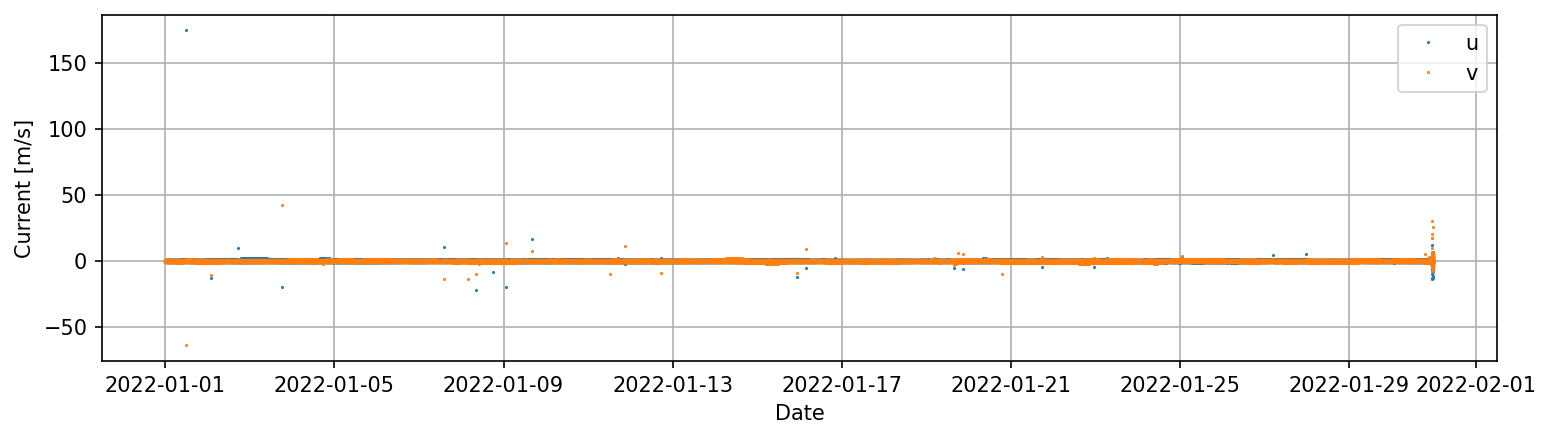

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12, 3), dpi=150)
ax.plot(ds_sub.time, u, linestyle="", marker=".", ms=1, label="u")
ax.plot(ds_sub.time, v, linestyle="", marker=".", ms=1, label="v")
ax.legend()
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Current [m/s]")

There are some unrealistically large values here, so something is wrong with our velocity calculation.
What could it be?
Recall that our data is stored as a contiguous ragged array, which means that longitude, latitude, and time values (as well as all other variables in the dataset) are stored as long 1-dimensional arrays that consist of many contiguous trajectories that are concatenated in memory.
As `velocity_from_position` is not aware of the "raggedness" of its input variables, the finite difference algorithm is applied across different trajectories, which is not what we want!
Fortunately, CloudDrift's `ragged` module provides the [`apply_ragged` function](https://clouddrift.org/_autosummary/clouddrift.ragged.apply_ragged.html#clouddrift.ragged.apply_ragged), which is a high-level function that allows you to apply any function that operates on contiguous 1-dimensional arrays, while respecting the boundaries of contiguoust trajectories in the ragged array.

In [10]:
cd.ragged.apply_ragged?

Signature:
cd.ragged.apply_ragged(
    func: <built-in function callable>,
    arrays: Union[list[Union[numpy.ndarray, xarray.core.dataarray.DataArray]], numpy.ndarray, xarray.core.dataarray.DataArray],
    rowsize: Union[list[int], numpy.ndarray[int], xarray.core.dataarray.DataArray],
    *args: tuple,
    rows: Union[int, Iterable[int]] = None,
    axis: int = 0,
    executor: concurrent.futures._base.Executor = <concurrent.futures.thread.ThreadPoolExecutor object at 0x7f474dec4190>,
    **kwargs: dict,
) -> Union[tuple[numpy.ndarray], numpy.ndarray]
Docstring:
Apply a function to a ragged array.

The function ``func`` will be applied to each contiguous row of ``arrays`` as
indicated by row sizes ``rowsize``. The output of ``func`` will be
concatenated into a single ragged array.

You can pass ``arrays`` as NumPy arrays or xarray DataArrays, however,
the result will always be a NumPy array. Passing ``rows`` as an integer or
a sequence of integers will make ``apply_ragged`` process an

In [11]:
u, v = cd.ragged.apply_ragged(
    cd.kinematics.velocity_from_position,
    [ds_sub.longitude, ds_sub.latitude, ds_sub.time],
    ds_sub.rowsize
)
u *= 1e9  # m/ns -> m/s
v *= 1e9  # m/ns -> m/s

Text(0, 0.5, 'Current [m/s]')

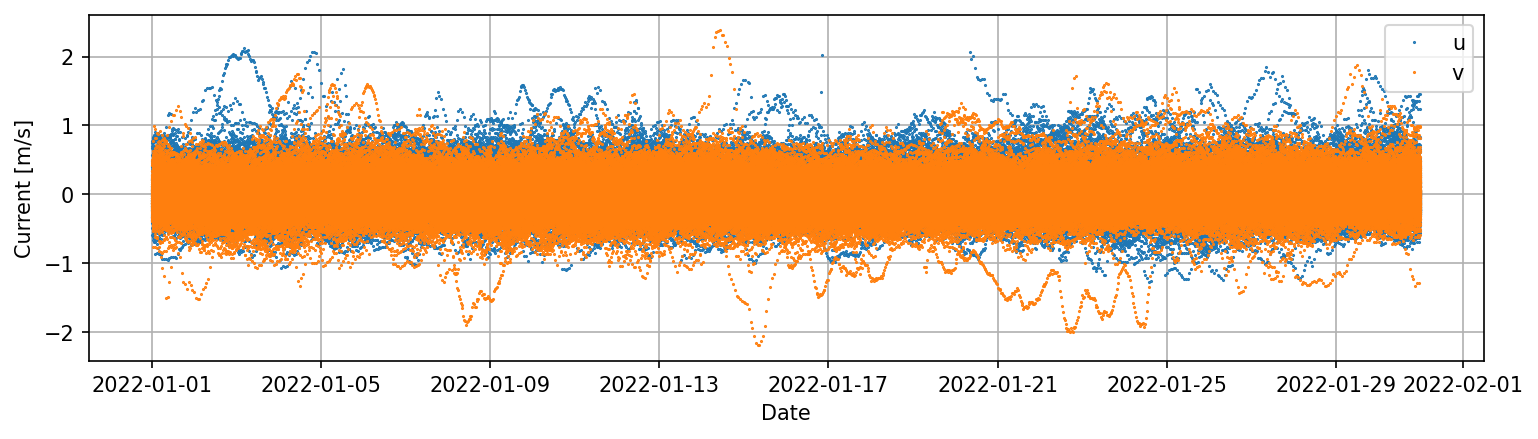

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12, 3), dpi=150)
ax.plot(ds_sub.time, u, linestyle="", marker=".", ms=1, label="u")
ax.plot(ds_sub.time, v, linestyle="", marker=".", ms=1, label="v")
ax.legend()
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Current [m/s]")

Although there's a lot of overlapping data that makes it difficult to see individual trajecories' velocities, we can see that the values are overall in a realistic range. Let's compute current magnitude and direction as we'll use these quantities in the remaining analysis in this notebook.

In [13]:
current_magnitude = np.sqrt(u**2 + v**2)
current_direction = np.arctan2(v, u)

## Plotting current magnitude from all drifters in the period of interest

In [14]:
proj = ccrs.PlateCarree(central_longitude=180)

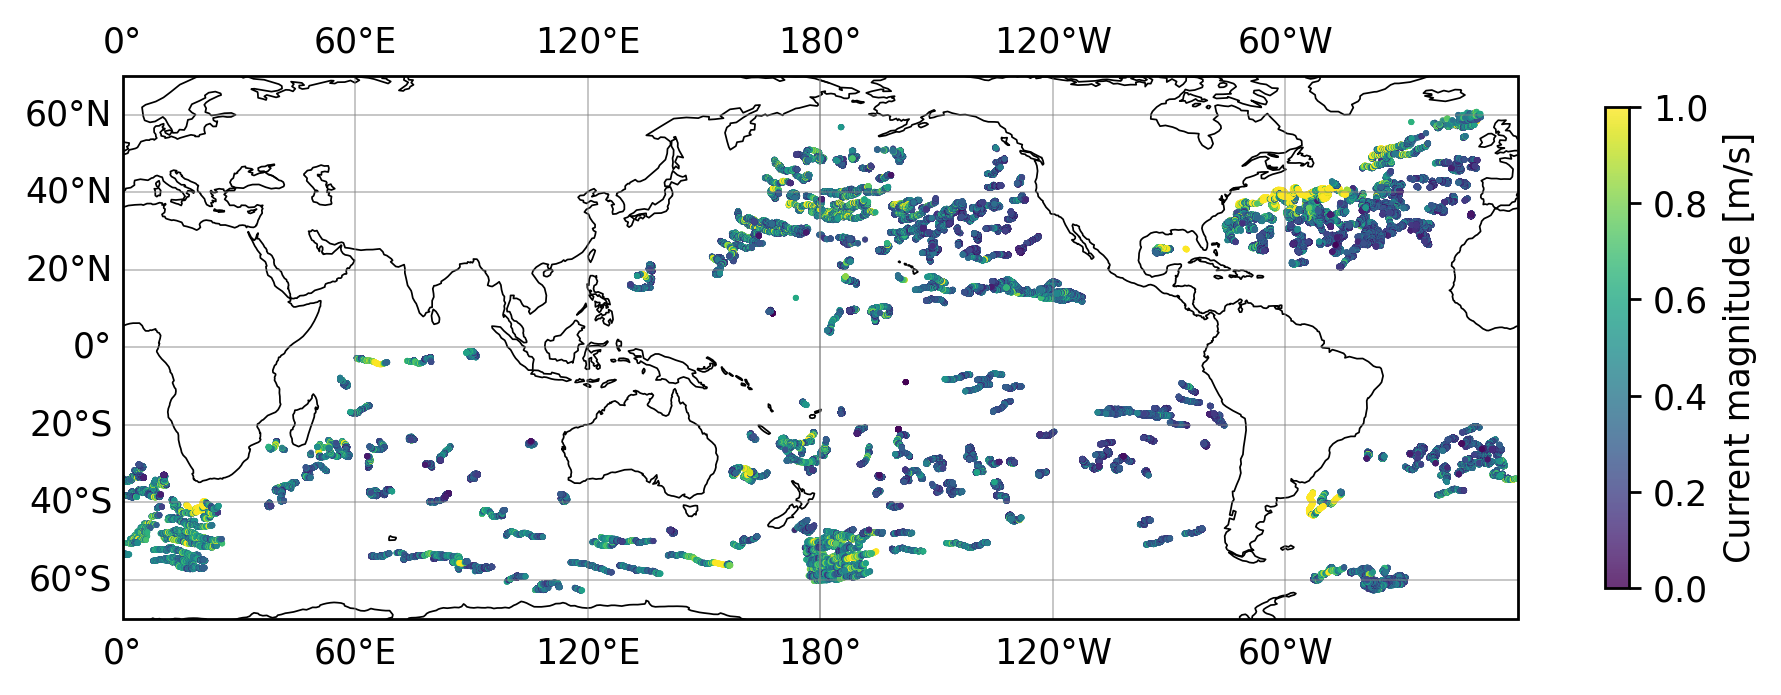

In [15]:
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines(linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=.5, color='gray', alpha=0.5)
ax.set_extent([0, 360, -70, 70], crs=ccrs.PlateCarree())

pcm1 = ax.scatter(
    ds_sub.longitude, 
    ds_sub.latitude,
    c=current_magnitude,
    s=0.5,
    cmap=cm.viridis,
    alpha=0.8,
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree()
)

cb = fig.colorbar(pcm1, ax=ax, label='Current magnitude [m/s]', shrink=0.5)

Cool, we can see the Spotter drifters in the Gulf Stream and the Brazil and Aghulas Currents stand out with high magnitude.

Now that we have both the currents and wave data for the same set of drifters, it could be interesting to look at regions where current and wave directions are aligned or misaligned.

Since our current direction is defined in the math convention (0 toward East, increasing counter-clockwise), while the Spotter peak wave direction is defined in the meteorological convention (0 from North, increasing clockwise), we'll re-cast the peak wave direction into the math convention so we can calculate the angles between two vectors.

In the code snippet that follows the `90` part is the offset to account for the start of the angle; the `- ds_sub.peakDirection` accounts for the opposite direction in which the angle increases in the two conventions, and `+ 180` accounts for the from/toward orientation between the two conventions. Finally, we convert to radians and normalize to the $[-\pi, \pi]$ range.

In [16]:
peak_wave_direction = np.radians((90 - ds_sub.peakDirection + 180) % 360)
peak_wave_direction[peak_wave_direction > np.pi] -= 2 * np.pi

Text(0.5, 1.0, 'Histogram of current and peak wave directions')

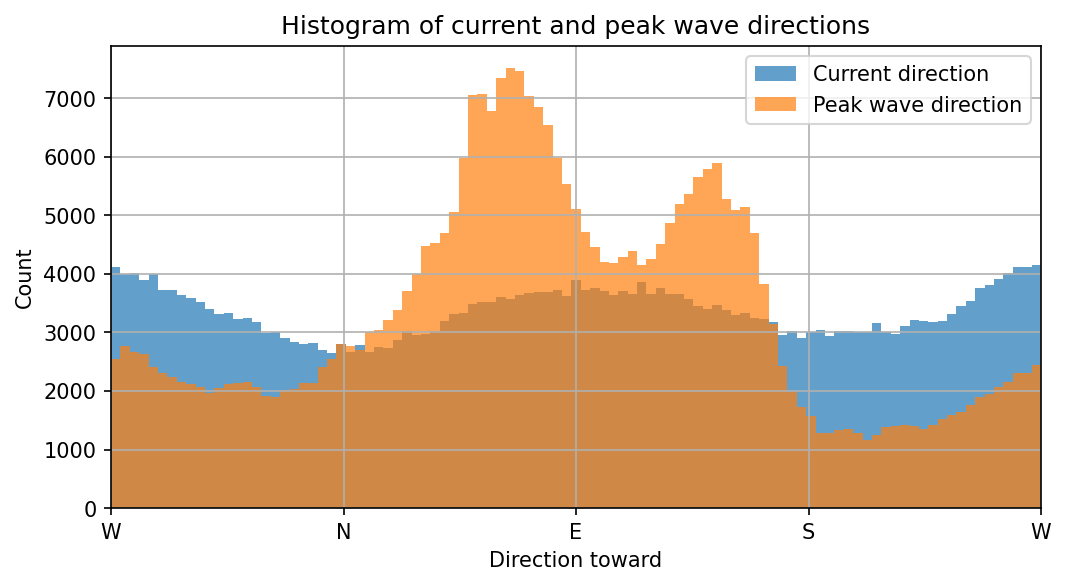

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8, 4), dpi=150)
ax.hist(current_direction, bins=np.linspace(-np.pi, np.pi, 100), alpha=0.7, label="Current direction")
ax.hist(peak_wave_direction, bins=np.linspace(-np.pi, np.pi, 100), alpha=0.7, label="Peak wave direction")
ax.set_xticks(np.linspace(-np.pi, np.pi, 5))
ax.set_xticklabels(["W", "N", "E", "S", "W"])
ax.set_xlabel("Direction toward")
ax.set_ylabel("Count")
ax.set_xlim(-np.pi, np.pi)
ax.legend()
ax.grid()
ax.set_title("Histogram of current and peak wave directions")

As expected, the currents tend to be a tad more zonal than meridional, while the peaks of wave spectra tend to be oriented toward northeast and southeast due waves being dominated by mid-latitude storms that propagate eastward.

Let's look at the world map of wave-current misalignment, indicated by the cosine of their angle difference (red indicates currents aligned with waves, blue indicates currents against waves).

Text(0.5, 1.0, 'Wave-current alignment')

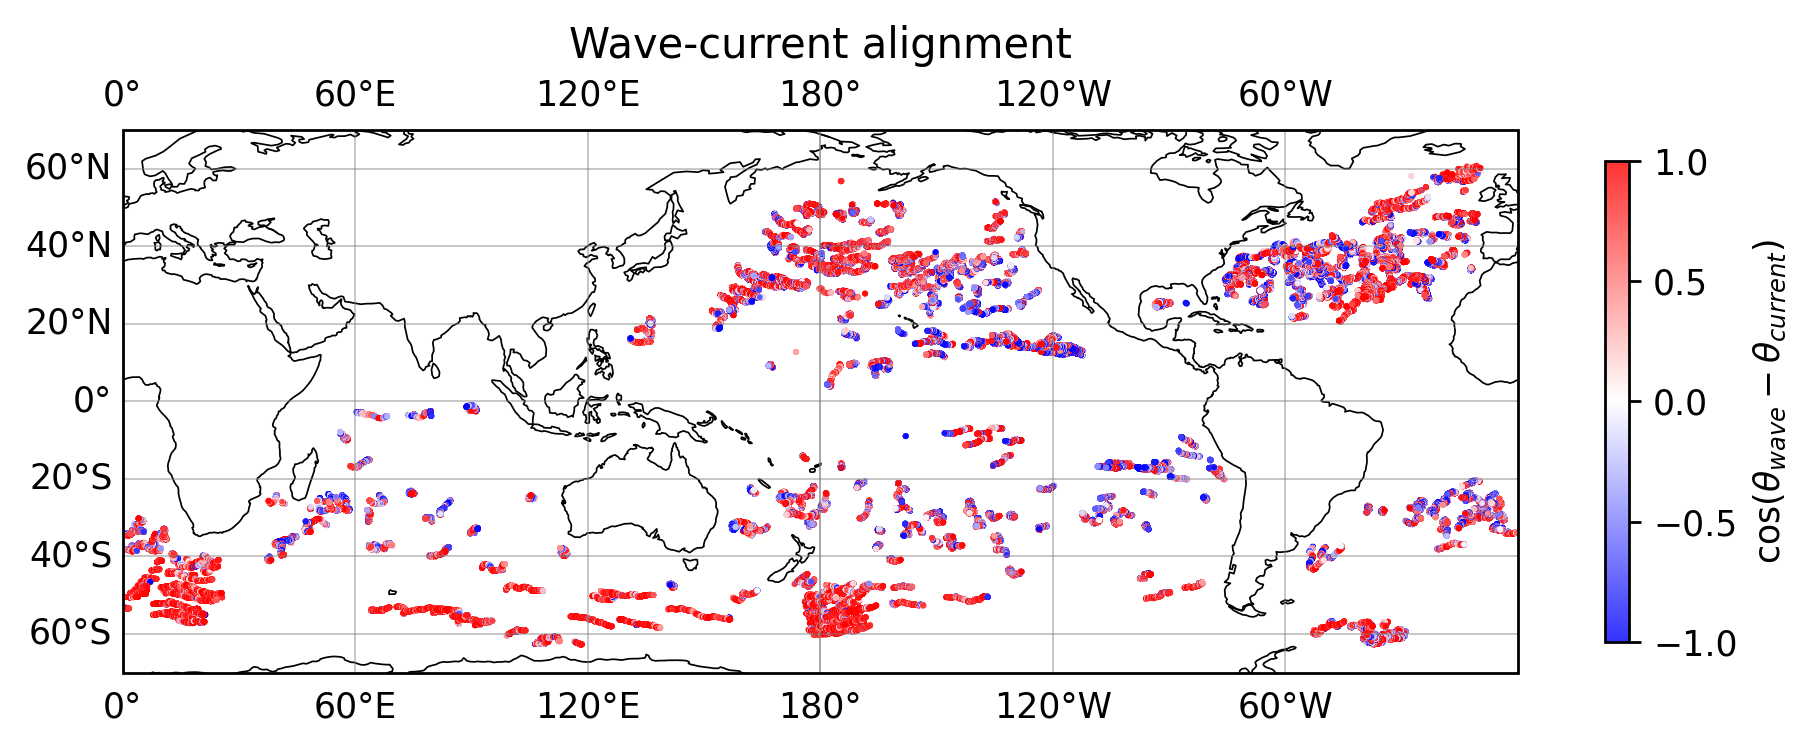

In [18]:
fig, ax = plt.subplots(1,1, figsize=[9,5], subplot_kw={'projection': proj}, dpi=250)
ax.coastlines(linewidth=0.5)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=.5, color='gray', alpha=0.5)
ax.set_extent([0, 360, -70, 70], crs=ccrs.PlateCarree())

pcm1 = ax.scatter(
    ds_sub.longitude, 
    ds_sub.latitude,
    c=np.cos(peak_wave_direction - current_direction),
    s=0.5,
    cmap=cm.bwr,
    alpha=0.8,
    vmin=-1, vmax=1,
    transform=ccrs.PlateCarree()
)

cb = fig.colorbar(pcm1, ax=ax, label=r"$\cos(\theta_{wave} - \theta_{current})$", shrink=0.5)
ax.set_title("Wave-current alignment")

## Conclusion

In this notebook, you learned how to:

* Load remote Spotter data from S3 as an Xarray Dataset;
* Subset the data for a desired time period using `clouddrift.ragged.subset`;
* Compute velocities from Spotter positions using `clouddrift.kinematics.velocity_from_position`;
* Apply a function to a ragged-array dataset while respecting contiguous trajectory boundaries using `clouddrift.ragged.apply_ragged`

to perform some basic wave-current analysis from Spotter data.